# 05_mini-AlexNet-train

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import matplotlib.pyplot as plt
from  matplotlib.colors import TwoSlopeNorm
import torch.nn.functional as F
from scipy.stats import bernoulli

In [4]:
from src.CNN_pruning import PruneNet

# Data

In [5]:
from src.load_CIFAR10 import get_train_valid_loader, get_test_loader

In [6]:
train_loader, valid_loader = get_train_valid_loader(
    data_dir='./data/', batch_size=128, random_seed=1, 
    augment=False, download=True, subsample_frac=0.10
)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
test_loader = get_test_loader(data_dir='./data', batch_size=128)

Files already downloaded and verified


# Train

In [9]:
num_classes = 10 # output number of classes
num_epochs = 20  # number of total training loops?
# batch_size = 128  # how much data to train on at a time
learning_rate = 0.005 # SGD step size. Scheduler with 0.1 for 0-100, 0.01 for 100-200, and 0.001 for 200 to 250

model = PruneNet(num_training_iter=num_epochs, num_classes=num_classes, verbose=False).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=learning_rate, 
)

# TODO: what is weight_decay and momentum?

total_step = len(train_loader)

In [383]:
total_step = len(train_loader)

train_losses = {}
val_losses = {}
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    num_train_batches = 0
    
    for i, (images, labels) in tqdm.tqdm(enumerate(train_loader), total=total_step, desc=f"Epoch {epoch} Training"):
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        num_train_batches += 1
    
    # Store average loss for the epoch
    train_losses[epoch] = running_loss / num_train_batches
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Training Loss: {train_losses[epoch]:.4f}")
    
    # validation (your existing validation code)
    model.eval()
    
    val_loss_fn = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        val_loss = 0.
        total = 0.
        correct = 0.

        num_val_batches = 0
        for val_batch, (images, labels) in enumerate(valid_loader):
            pred = model(images)
            val_loss += val_loss_fn(pred, labels).item()

            # print("pred.data", pred.data)
            _, predicted = torch.max(pred.data, 1)
            # print("predicted= ", predicted)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            num_val_batches += 1.0
            
        val_losses[epoch] = val_loss / total
        print(f"Average Val loss: {val_losses[epoch]:7f}")
        print(f"Accuracy of network on validation images: {100 * correct / total}%")


    # prune
    
    
        

Epoch 0 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.22it/s]


Epoch [1/20], Average Training Loss: 2.9580
Average Val loss: 2.020741
Accuracy of network on validation images: 28.6%


Epoch 1 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.53it/s]


Epoch [2/20], Average Training Loss: 2.3840
Average Val loss: 1.936081
Accuracy of network on validation images: 30.6%


Epoch 2 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.88it/s]


Epoch [3/20], Average Training Loss: 2.2346
Average Val loss: 1.912420
Accuracy of network on validation images: 32.0%


Epoch 3 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.91it/s]


Epoch [4/20], Average Training Loss: 2.1472
Average Val loss: 1.901748
Accuracy of network on validation images: 31.2%


Epoch 4 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.96it/s]


Epoch [5/20], Average Training Loss: 2.0797
Average Val loss: 1.863315
Accuracy of network on validation images: 34.4%


Epoch 5 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.89it/s]


Epoch [6/20], Average Training Loss: 2.0044
Average Val loss: 1.836933
Accuracy of network on validation images: 32.6%


Epoch 6 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.58it/s]


Epoch [7/20], Average Training Loss: 2.0045
Average Val loss: 1.817687
Accuracy of network on validation images: 34.4%


Epoch 7 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:10<00:00,  3.49it/s]


Epoch [8/20], Average Training Loss: 1.9429
Average Val loss: 1.791286
Accuracy of network on validation images: 37.4%


Epoch 8 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.59it/s]


Epoch [9/20], Average Training Loss: 1.8944
Average Val loss: 1.758522
Accuracy of network on validation images: 40.0%


Epoch 9 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.35it/s]


Epoch [10/20], Average Training Loss: 1.8964
Average Val loss: 1.751452
Accuracy of network on validation images: 38.6%


Epoch 10 Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:10<00:00,  3.47it/s]


Epoch [11/20], Average Training Loss: 1.8766
Average Val loss: 1.726188
Accuracy of network on validation images: 40.6%


Epoch 11 Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.17it/s]


Epoch [12/20], Average Training Loss: 1.8516
Average Val loss: 1.696284
Accuracy of network on validation images: 39.8%


Epoch 12 Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.24it/s]


Epoch [13/20], Average Training Loss: 1.8330
Average Val loss: 1.671166
Accuracy of network on validation images: 41.4%


Epoch 13 Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.29it/s]


Epoch [14/20], Average Training Loss: 1.8035
Average Val loss: 1.670646
Accuracy of network on validation images: 42.0%


Epoch 14 Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.60it/s]


Epoch [15/20], Average Training Loss: 1.7921
Average Val loss: 1.655135
Accuracy of network on validation images: 43.4%


Epoch 15 Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.19it/s]


Epoch [16/20], Average Training Loss: 1.7803
Average Val loss: 1.641866
Accuracy of network on validation images: 41.8%


Epoch 16 Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.57it/s]


Epoch [17/20], Average Training Loss: 1.7135
Average Val loss: 1.623502
Accuracy of network on validation images: 40.4%


Epoch 17 Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.48it/s]


Epoch [18/20], Average Training Loss: 1.7264
Average Val loss: 1.615244
Accuracy of network on validation images: 43.2%


Epoch 18 Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.41it/s]


Epoch [19/20], Average Training Loss: 1.7294
Average Val loss: 1.603103
Accuracy of network on validation images: 43.4%


Epoch 19 Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch [20/20], Average Training Loss: 1.7004
Average Val loss: 1.580858
Accuracy of network on validation images: 44.2%


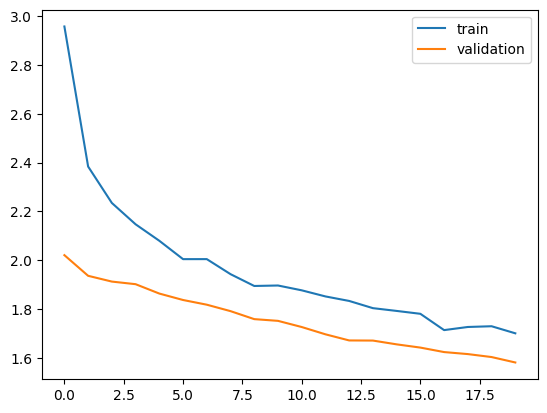

In [384]:
plt.plot(train_losses.keys(), train_losses.values(), label='train')
plt.plot(val_losses.keys(), val_losses.values(), label='validation')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [386]:
model.eval()
    
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')
test_losses = {}
with torch.no_grad():
    test_loss = 0.
    total = 0.
    correct = 0.

    num_test_batches = 0
    for test_batch, (images, labels) in enumerate(test_loader):
        pred = model(images)
        test_loss += test_loss_fn(pred, labels).item()

        # print("pred.data", pred.data)
        _, predicted = torch.max(pred.data, 1)
        # print("predicted= ", predicted)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        num_test_batches += 1.0
        
    test_losses[epoch] = test_loss / total
    print(f"Average test loss: {test_losses[epoch]:7f}")
    print(f"Accuracy of network on test images: {100 * correct / total}%")

Average test loss: 1.633429
Accuracy of network on test images: 40.03%


In [ ]:
# print(model.conv1.weight)
print((model.active_conv1_kernels == 0.0).sum())

In [282]:
(model.conv1.weight == 0.0).all(axis=(1, 2, 3))

torch.Size([64])

In [174]:
X = torch.ones(64,3,5,5) * np.arange(64).reshape(-1, 1, 1, 1)
print(X.shape)
# print(X)

L2 = X.pow(2).sum(dim=(1, 2, 3)).pow(0.5)
print(L2)
sort_idx = np.argsort(L2)
print(sort_idx)

# remove lowest k
gamma = 0.1
remove_num = int(len(sort_idx) * gamma )
print(remove_num)

print(sort_idx[remove_num:])
print(sort_idx[remove_num:].shape)


torch.Size([64, 3, 5, 5])
tensor([  0.0000,   8.6603,  17.3205,  25.9808,  34.6410,  43.3013,  51.9615,
         60.6218,  69.2820,  77.9423,  86.6025,  95.2628, 103.9230, 112.5833,
        121.2436, 129.9038, 138.5641, 147.2243, 155.8846, 164.5448, 173.2051,
        181.8653, 190.5256, 199.1858, 207.8461, 216.5064, 225.1666, 233.8269,
        242.4871, 251.1474, 259.8076, 268.4679, 277.1281, 285.7884, 294.4486,
        303.1089, 311.7691, 320.4294, 329.0897, 337.7499, 346.4102, 355.0704,
        363.7307, 372.3909, 381.0512, 389.7114, 398.3717, 407.0319, 415.6922,
        424.3524, 433.0127, 441.6730, 450.3332, 458.9935, 467.6537, 476.3140,
        484.9742, 493.6345, 502.2947, 510.9550, 519.6152, 528.2755, 536.9358,
        545.5960], dtype=torch.float64)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 

In [130]:
np.sqrt(300)

17.320508075688775